### Learning of Structured data
#### Skeleton Data Time Series Classification




In [3]:
import torch
from torch import nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from datetime import datetime
import glob, os
from IPython.display import display
import numpy as np
import random as random

# set the device which will be used to train the model
device = torch.device('cuda:0' if torch.cuda.device_count() >= 1 else 'cpu')

#### Exercise1: Data Set Exploration and Visualization

In [4]:
train_path = './train'
test_path = './test'
train_file_names = open("train.txt", "r").read().splitlines()
eval_file_names = open("eval.txt", "r").read().splitlines()
test_file_names = os.listdir(test_path)

In [5]:
mapping_labels = {"boxing" : 0, "drums" : 1, "guitar" : 2, "rowing" : 3, "violin" : 4}
num_categories = 5

In [6]:
test_file_names.sort(key=lambda x: int(x[:x.index('.')]))

In [7]:
## remove ankle

train_data_frame_list = []
eval_data_frame_list = []
eval_index_list = []
for index in range(len(train_file_names)):
    with open(os.path.join(train_path, train_file_names[index]), "r") as f:
        content = f.readlines()
        train_data_frame_list.append(pd.DataFrame([[float(p) for p in st.split(',')] for st in content[:len(content) // 2]]))
        train_data_frame_list[-1].columns = [str(i) for i in range(len(train_data_frame_list[-1].columns))]

for index in range(len(eval_file_names)):
    with open(os.path.join(train_path, eval_file_names[index]), "r") as f:
        content = f.readlines()
        eval_data_frame_list.append(pd.DataFrame([[float(p) for p in st.split(',')] for st in content[:len(content) // 2]]))
        eval_data_frame_list[-1].columns = [str(i) for i in range(len(eval_data_frame_list[-1].columns))]
        eval_index_list.append(index)

train_data_frame_list[0]

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
0,253.674301,102.96611,0.9078,269.803192,191.368973,0.785458,201.43306,201.431473,0.8228,181.371231,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
1,253.000000,102.00000,1.0000,270.000000,191.000000,1.000000,201.00000,202.000000,1.0000,181.000000,...,0.0,-0.159373,0.426741,0.0,-0.159373,0.426741,0.0,-0.159373,0.426741,0.0
2,253.000000,102.00000,1.0000,272.000000,189.000000,1.000000,201.00000,203.000000,1.0000,181.000000,...,0.0,-0.199359,0.532487,0.0,-0.199359,0.532487,0.0,-0.199359,0.532487,0.0
3,253.000000,102.00000,1.0000,272.000000,189.000000,1.000000,202.00000,204.000000,1.0000,182.000000,...,0.0,0.272133,0.604508,0.0,0.272133,0.604508,0.0,0.272133,0.604508,0.0
4,254.000000,101.00000,1.0000,273.000000,189.000000,1.000000,203.00000,204.000000,1.0000,184.000000,...,0.0,-0.865690,-4.388336,0.0,-0.865690,-4.388336,0.0,-0.865690,-4.388336,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,269.000000,86.00000,1.0000,291.000000,182.000000,1.000000,215.00000,193.000000,1.0000,196.000000,...,0.0,-25.497719,3.344067,0.0,-25.497719,3.344067,0.0,-25.497719,3.344067,0.0
218,273.000000,85.00000,1.0000,295.000000,182.000000,1.000000,219.00000,193.000000,1.0000,199.000000,...,0.0,-25.458832,3.297691,0.0,-25.458832,3.297691,0.0,-25.458832,3.297691,0.0
219,277.000000,85.00000,1.0000,300.000000,182.000000,1.000000,223.00000,191.000000,1.0000,202.000000,...,0.0,-25.466545,3.380524,0.0,-25.466545,3.380524,0.0,-25.466545,3.380524,0.0
220,282.000000,84.00000,1.0000,305.000000,182.000000,1.000000,230.00000,190.000000,1.0000,204.000000,...,0.0,-25.506676,3.337200,0.0,-25.506676,3.337200,0.0,-25.506676,3.337200,0.0


In [25]:
test_data_frame_list = []
for index in range(len(test_file_names)):
    with open(os.path.join(test_path, test_file_names[index]), "r") as f:
        content = f.readlines()
        test_data_frame_list.append(pd.DataFrame([[float(p) for p in st.split(',')] for st in content[:len(content) // 2]]))
        test_data_frame_list[-1].columns = [str(i) for i in range(len(test_data_frame_list[-1].columns))]

In [28]:
## nan for x y cordinates when confidence =0

for i in range(2, 75, 3):
    for df in train_data_frame_list:
        df.loc[df[str(i)] == 0, [str(i-2), str(i-1)]] = np.nan

if len(eval_data_frame_list) > 0:
    for i in range(2, 75, 3):
        for df in eval_data_frame_list:
            df.loc[df[str(i)] == 0, [str(i-2), str(i-1)]] = np.nan

for i in range(2, 75, 3):
    for df in test_data_frame_list:
        df.loc[df[str(i)] == 0, [str(i-2), str(i-1)]] = np.nan

In [31]:
train_data_frame = pd.concat(train_data_frame_list)
train_data_frame = train_data_frame.reset_index(drop=True)  ##

In [32]:
idx_maping = {2: "Nose", 5: "Neck", 8: "R Shoulder", 11: "R_Elbow", 14: "R_Wrist", 17: "L_Shoulder", 
            20: "L_Elbow", 23: "L_Wrist", 26: "M_Hip", 29: "R_Hip", 32: "R_Nee", 35: "R_Ankle", 38: "L_Hip", 
            41: "L_Nee", 44: "L_Ankle", 47: "R_Eye", 50: "L_Eye", 53: "R_Ear", 56: "L_Ear", 59: "L_Big_Toe", 
            62: "L_Small_Toe", 65: "L_Heel", 68: "R_Big_Toe", 71: "R_Small_Toe", 74: "R_Heel"}

for i in range(2, 75, 3):
    l = len(train_data_frame.loc[train_data_frame[str(i)] == 0])
    if (l > 0.9 * len(train_data_frame)):
        for df in train_data_frame_list:
            df.drop([str(i-2), str(i-1)], axis=1, inplace=True)
        if len(eval_data_frame_list) > 0:
            for df in eval_data_frame_list:
                df.drop([str(i-2), str(i-1)], axis=1, inplace=True)
        for df in test_data_frame_list:
            df.drop([str(i-2), str(i-1)], axis=1, inplace=True)
        print(idx_maping[i], " " * (11 - len(idx_maping[i])), i, l, "dropped")
    else:
        print(idx_maping[i], " " * (11 - len(idx_maping[i])), i, l)

Nose         2 114
Neck         5 3
R Shoulder   8 5
R_Elbow      11 47
R_Wrist      14 558
L_Shoulder   17 5
L_Elbow      20 31
L_Wrist      23 574
M_Hip        26 6
R_Hip        29 14
R_Nee        32 209974
R_Ankle      35 260481 dropped
L_Hip        38 13
L_Nee        41 203724
L_Ankle      44 260517 dropped
R_Eye        47 247
L_Eye        50 162
R_Ear        53 20812
L_Ear        56 20926
L_Big_Toe    59 260523 dropped
L_Small_Toe  62 260524 dropped
L_Heel       65 260521 dropped
R_Big_Toe    68 260520 dropped
R_Small_Toe  71 260520 dropped
R_Heel       74 260523 dropped


In [33]:
for df in train_data_frame_list:
    df.drop([str(i) for i in range(2, 75, 3)], axis=1, inplace=True)
for df in eval_data_frame_list:
    df.drop([str(i) for i in range(2, 75, 3)], axis=1, inplace=True)
for df in test_data_frame_list:
    df.drop([str(i) for i in range(2, 75, 3)], axis=1, inplace=True)

train_data_frame_list[0]

,0,1,3,4,6,7,9,10,12,13,...,39,40,45,46,48,49,51,52,54,55
0,253.0,102.0,270.0,191.0,201.0,202.0,181.0,305.0,172.0,395.0,...,NaN,NaN,235.0,89.0,267.0,86.0,221.0,107.0,296.0,93.0
1,253.0,102.0,272.0,189.0,201.0,203.0,181.0,304.0,175.0,391.0,...,NaN,NaN,235.0,89.0,267.0,86.0,221.0,107.0,296.0,92.0
2,253.0,102.0,272.0,189.0,202.0,204.0,182.0,303.0,178.0,387.0,...,NaN,NaN,235.0,89.0,267.0,86.0,221.0,107.0,296.0,92.0
3,254.0,101.0,273.0,189.0,203.0,204.0,184.0,302.0,182.0,383.0,...,NaN,NaN,235.0,89.0,268.0,85.0,221.0,107.0,297.0,91.0
4,255.0,101.0,274.0,189.0,205.0,204.0,186.0,301.0,186.0,380.0,...,NaN,NaN,236.0,89.0,269.0,84.0,222.0,107.0,298.0,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,269.0,86.0,291.0,182.0,215.0,193.0,196.0,292.0,178.0,365.0,...,NaN,NaN,252.0,78.0,285.0,69.0,239.0,96.0,316.0,85.0
217,273.0,85.0,295.0,182.0,219.0,193.0,199.0,293.0,181.0,376.0,...,NaN,NaN,256.0,77.0,289.0,68.0,243.0,95.0,317.0,84.0
218,277.0,85.0,300.0,182.0,223.0,191.0,202.0,294.0,184.0,385.0,...,NaN,NaN,262.0,75.0,293.0,68.0,247.0,95.0,321.0,84.0
219,282.0,84.0,305.0,182.0,230.0,190.0,204.0,297.0,187.0,397.0,...,NaN,NaN,267.0,74.0,298.0,67.0,251.0,94.0,326.0,84.0


In [34]:
num_features = len(train_data_frame_list[0].columns)
num_features

34

In [36]:
##TRim data for 150 rows

trimmed_train_data = []
for df in train_data_frame_list:
    if len(df) > 150:
        trimmed_train_data.append(df[:150])
    else:
        trimmed_train_data.append(df)

trimmed_eval_data = []
for df in eval_data_frame_list:
    if len(df) > 150:
        trimmed_eval_data.append(df[:150])
    else:
        trimmed_eval_data.append(df)

trimmed_test_data = []
for df in test_data_frame_list:
    if len(df) > 150:
        trimmed_test_data.append(df[:150])
    else:
        trimmed_test_data.append(df)

In [37]:
def Normalization(data):
  return (data - data.mean()) / data.std()

train_normalized_data_list = []
for df in trimmed_train_data:
  train_normalized_data_list.append(Normalization(df))
  train_normalized_data_list[-1].fillna(0, inplace=True)
train_normalized_data_list[0]

eval_normalized_data_list = []
for df in trimmed_eval_data:
  eval_normalized_data_list.append(Normalization(df))
  eval_normalized_data_list[-1].fillna(0, inplace=True)
eval_normalized_data_list[0]

test_normalized_data_list = []
for df in trimmed_test_data:
  test_normalized_data_list.append(Normalization(df))
  test_normalized_data_list[-1].fillna(0, inplace=True)
test_normalized_data_list[0]

,0,1,6,7,9,10,12,13,15,16,...,39,40,45,46,48,49,51,52,54,55
0,-1.430874,0.914059,-1.888175,1.432358,-0.014250,0.341488,-1.017347,1.082356,-2.264465,-2.388119,...,0.652205,1.215171,-1.435739,1.384625,-1.666109,1.374978,-1.035439,0.786350,-0.807154,-0.532474
1,-1.422707,0.619681,-1.774248,1.416993,0.065667,0.258215,-0.996685,0.868825,-1.852311,-2.086779,...,0.795061,0.960010,-1.426097,1.026802,-1.667863,1.042335,-1.109279,0.548817,-0.860386,0.093052
2,-1.346132,0.276231,-1.774248,1.416993,0.065667,2.371930,-0.867675,0.271986,-1.302392,-1.777176,...,0.957899,0.960010,-1.349311,0.809368,-1.569445,0.834533,-1.195076,0.548817,-0.907887,-0.214993
3,-1.346132,-0.067218,-0.838392,1.416993,0.065667,2.371930,-0.738664,-0.154328,-1.302392,-1.777176,...,1.039319,0.960010,-1.349311,0.591934,-1.569445,0.626730,-1.237974,0.548817,-0.955388,-0.523038
4,-1.346132,-0.238943,-0.838392,1.416993,0.065667,2.371930,-1.254707,-0.069065,-1.302392,-1.777176,...,1.120738,0.960010,-1.349311,0.374500,-1.471028,0.003324,-1.280873,0.548817,-1.002889,-0.831084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,1.257414,0.619681,0.097465,-1.887116,-1.093499,-1.279033,0.228917,-0.836430,1.447201,1.009251,...,-1.728934,0.960010,1.261393,-0.060368,1.186249,0.003324,1.722030,-1.528166,0.000000,0.000000
146,1.410564,0.791405,0.097465,-1.887116,-0.762309,-1.279033,0.357928,-1.518531,0.347363,1.009251,...,-1.647515,0.960010,1.338178,0.591934,1.284667,0.626730,1.679132,-0.749297,0.000000,0.000000
147,1.410564,1.306579,0.097465,-1.887116,-0.596714,-1.086877,0.422433,-1.859582,0.347363,0.699648,...,-1.566096,0.960010,1.414963,1.244236,1.383085,1.250137,1.636233,-0.489674,0.000000,0.000000
148,1.410564,1.650029,0.097465,-1.887116,0.065667,-0.702565,0.422433,-1.774320,0.347363,0.390045,...,-1.484677,0.960010,1.491749,1.679104,1.383085,1.665741,1.593334,-0.489674,0.000000,0.000000


In [38]:
num_features = len(train_normalized_data_list[0].columns)
num_features

32

## Exercise2: Embedding and Modeling

In [54]:
from dtaidistance import dtw, dtw_ndim
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

def DTW(s1, s2):
    dtw_i = []
    for dim in range(num_features):
        dtw_i.append(dtw.distance(s1[:, dim], s2[:,dim]))
    return dtw_i

In [55]:
DTW_train = np.load("20_DTW_train_1.npy",allow_pickle=True)
DTW_eval = np.load("20_DTW_eval_1.npy",allow_pickle=True)
DTW_test = np.load("20_DTW_test_1.npy",allow_pickle=True)

In [59]:
idx_maping = {2: "Nose", 5: "Neck", 8: "R Shoulder", 11: "R_Elbow", 14: "R_Wrist", 17: "L_Shoulder", 
            20: "L_Elbow", 23: "L_Wrist", 26: "M_Hip", 29: "R_Hip", 32: "R_Nee", 35: "R_Ankle", 38: "L_Hip", 
            41: "L_Nee", 44: "L_Ankle", 47: "R_Eye", 50: "L_Eye", 53: "R_Ear", 56: "L_Ear", 59: "L_Big_Toe", 
            62: "L_Small_Toe", 65: "L_Heel", 68: "R_Big_Toe", 71: "R_Small_Toe", 74: "R_Heel"}
columns = [4, 5, 6, 7, 10, 11, 12, 13]
train_data_frame_list[0].columns[columns]

Index(['9', '10', '12', '13', '18', '19', '21', '22'], dtype='object')

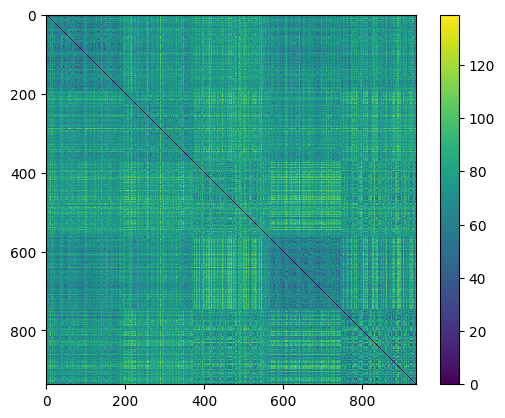

In [60]:
D_train = np.zeros((len(DTW_train), len(DTW_train)))
for i in range(len(DTW_train)):
    for j in range(len(DTW_train)):
        D_train[i,j] = DTW_train[i,j][columns].sum()
plt.imshow(D_train, interpolation='nearest')
plt.colorbar()

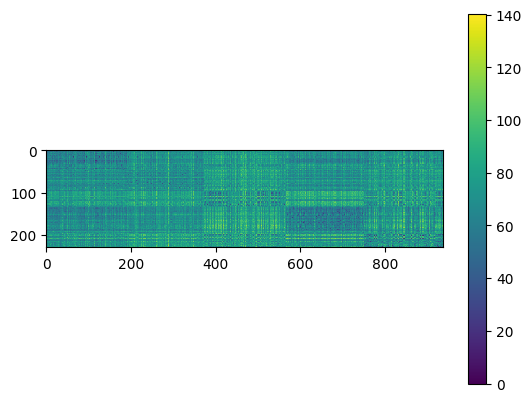

In [61]:
D_eval = np.zeros((len(DTW_eval), len(DTW_train)))
for i in range(len(DTW_eval)):
    for j in range(len(DTW_train)):
        D_eval[i,j] = DTW_eval[i,j][columns].sum()
plt.imshow(D_eval, interpolation='nearest')
plt.colorbar()

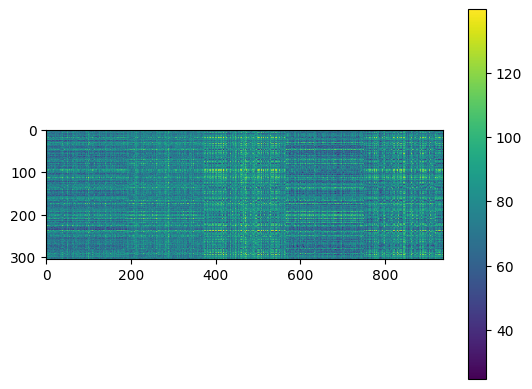

In [62]:
D_test = np.zeros((len(DTW_test), len(DTW_train)))
for i in range(len(DTW_test)):
    for j in range(len(DTW_train)):
        D_test[i,j] = DTW_test[i,j][columns].sum()
plt.imshow(D_test, interpolation='nearest')
plt.colorbar()

#### Perform spectral embedding on the distance matrix D_train to obtain a low-dimensional representation of the time series data. 

In [63]:
n = D_train.shape[0]
## the size of the first dimension of the D_train array, which should be equal to the number of time series in the dataset.

In [64]:
J = np.identity(n) - np.ones(n)/n
## This line creates a centering matrix J with shape (n, n). The matrix subtracts the mean of each row and column of D_train
# from the corresponding entries.

In [65]:
S_train = -0.5*J @ D_train @ J
## computes the similarity matrix S_train by applying a negative exponential kernel to the centered distance matrix D_train.
# The kernel has bandwidth gamma = 0.5 and the centering matrix J is used to normalize the distances.

In [67]:
w, u = np.linalg.eig(S_train)
## This line computes the eigenvalues and eigenvectors of the similarity matrix S_train.
# The eigenvalues are stored in the array w and the eigenvectors are stored as columns of the matrix u.

In [68]:
idx = w.argsort()[::-1][:]
## This line sorts the eigenvalues in descending order and stores the indices of the sorted array in idx.

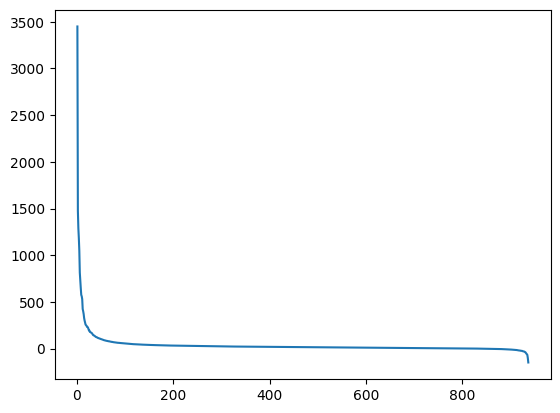

In [69]:
plt.plot(range(1, n+1),w[idx])
## This line plots the sorted eigenvalues as a function of their index.

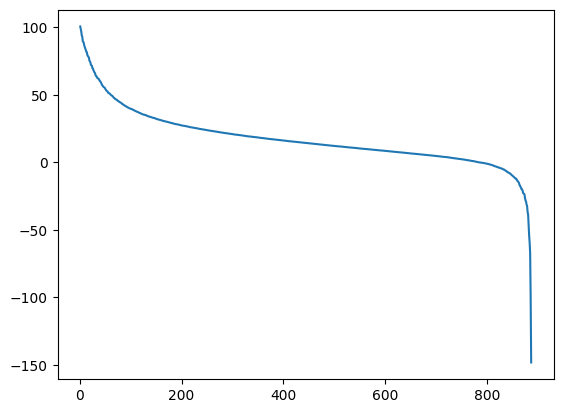

In [70]:
d=50  ## sets the number of dimensions for the low-dimensional representation to d.
plt.plot(range(1, n-d+1),w[idx][d:])

## plots the eigenvalues for the top d eigenvectors.

In [71]:
u[:,idx[:d]].shape

## prints the shape of the matrix containing the top d eigenvectors of S_train.

(937, 50)

In [72]:
train_embedding_data = u[:,idx[:d]] @ np.diag(w[idx[:d]]**0.5)
train_embedding_data

## This line computes the low-dimensional representation of the time series data by multiplying 
# top d eigenvectors of S_train with the square root of the corresponding eigenvalues. 

array([[ 0.96463784, -1.59685473,  0.9506363 , ...,  0.29026702,
         0.26307035, -0.47722986],
       [-0.49927305,  1.47347791,  1.09662834, ..., -0.18768086,
         0.03038738,  0.0403349 ],
       [-0.30077519,  1.43445908,  1.02810988, ..., -0.14876995,
        -0.03034163,  0.04385052],
       ...,
       [ 1.04806451,  0.24363043, -0.67752231, ..., -0.14941991,
         0.48460362, -0.45767955],
       [-3.72373702, -0.98480925, -0.74227828, ..., -0.0301928 ,
         0.45887874,  0.16260562],
       [ 1.39663839, -0.15842504,  0.04504848, ...,  0.40133177,
         0.32936979, -0.1950478 ]])

In [73]:
U_1 = np.ones((len(D_eval), len(D_train))) / n
S_eval = -0.5 * (D_eval @ J - U_1 @ D_train @ J)

In [74]:
eval_embedding_data = S_eval @ u[:,idx[:d]] @ np.diag(w[idx[:d]]**-0.5) @ np.identity(d)

In [75]:
U_1 = np.ones((len(D_test), len(D_train))) / n
S_test = -0.5 * (D_test @ J - U_1 @ D_train @ J)

In [76]:
test_embedding_data = S_test @ u[:,idx[:d]] @ np.diag(w[idx[:d]]**-0.5) @ np.identity(d)

In [77]:
from sklearn.preprocessing import StandardScaler
norm = StandardScaler()
train_embedding_data = norm.fit_transform(train_embedding_data)
eval_embedding_data = norm.transform(eval_embedding_data)
test_embedding_data = norm.transform(test_embedding_data)

## Exercise3: Evaluation

### 1. CNN and Multilayer Perceptron

In [78]:
class Create_Dataset(Dataset):
  def __init__(self, train_embedding_data):
    self.data = torch.tensor(train_embedding_data) # Shape = [num_samples, features]
    self.labels = torch.tensor([mapping_labels[name[name.index('_')+1: name.index('.')]] for name in train_file_names]) # Shape = [num_samples]

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

In [79]:
batch_size = 30
dataset = Create_Dataset(train_embedding_data)
dl_train = DataLoader(dataset, batch_size, shuffle=True)
next(iter(dl_train))[0].shape

torch.Size([30, 50])

In [80]:
eval_input = torch.tensor(eval_embedding_data)
eval_labels = torch.tensor([mapping_labels[name[name.index('_')+1: name.index('.')]] for name in eval_file_names])

In [81]:
def Evaluation(model, type):
  model.eval()
  
  if type == "CNN":
    prediction = model(eval_input.unsqueeze(1).to(device))
  else:
    prediction = model(eval_input.to(device))
  
  pre = prediction.argmax(dim=1)

  return (pre == eval_labels).type(torch.float).sum() / len(eval_labels)

In [82]:
def Train_Model(model, model_type='MLP', learning_rate=0.1):
    # use CrossEntropyLoss for classification problem
    loss = nn.CrossEntropyLoss()
    # use SGD optimization
    optimizer = optim.SGD(model.parameters(), lr = learning_rate)
    #optimizer = optim.Adam(model.parameters(),lr=learning_rate.005,betas=(0.9,0.999),eps=1e-08,weight_decay=0,amsgrad=False)
    train_losses = []
    train_accuracies = []
    eval_accuracies = []
    best_loss = float('inf')
    best_model = model
    lr_idx = 0
    epoch = 0
    while learning_rate >= 1e-4:
        epoch += 1
        # set the model in training mode      
        model.train()
        train_loss, train_acc = 0., 0.
        for batch in dl_train:            
            # send the input to the device
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)
            if model_type == 'CNN':
                x_batch = x_batch.unsqueeze(1) # change shape to [num_batch, 1 channel, length]
            # perform a forward pass and calculate the training loss
            predictions = model(x_batch)
            l = loss(predictions, y_batch)

            # zero out the gradients, perform the backpropagation step, and update the weights
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_loss += l.item()*len(x_batch)
            train_acc += (predictions.argmax(dim=1) == y_batch).type(torch.float).sum().item()

        
        eval_acc = Evaluation(model, model_type)*100
        eval_accuracies.append(eval_acc)

        train_loss /= len(dl_train.dataset)
        train_acc /= len(dl_train.dataset)/100.
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
                  
        print(f"Epoch {'{:03d}'.format(epoch)} - Training loss: {'{:.3f}'.format(train_loss)} - Training accuracy: {'{:.2f}'.format(train_acc)}% - Eval accuracy: {'{:.2f}'.format(eval_acc)}% - Learning rate: {learning_rate}")

        # save the best model
        if (best_loss > train_loss):
            best_loss = train_loss
            best_model = model
            lr_idx = epoch
        
        # reduce the learning rate, if the loss has not reduced in the past epochs
        if lr_idx + 3 <= epoch:
            learning_rate /= 2.
            optimizer.param_groups[0]['lr'] = learning_rate
            lr_idx = epoch
            model = best_model
            
    # plot training loss and accuracy
    
    fig, (ax0, ax1, ax2) = plt.subplots(3, 1)
    fig.subplots_adjust(wspace = 0.3)
    ax0.plot(range(1, epoch+1), train_losses, 'blue')
    ax0.set_xlabel('Epoch')
    ax0.set_ylabel('Loss')
    ax0.set_title("Training losses")
    ax1.plot(range(1, epoch+1), train_accuracies, 'orange')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.set_title("Training accuracies")
    ax2.plot(range(1, epoch+1), eval_accuracies, 'orange')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title("Eval accuracies")
    
    return best_model

In [83]:
class CNN_NET(nn.Module):
  def __init__(self, length):
    super().__init__()
        
    self.net = nn.Sequential(nn.Conv1d(1, 8, kernel_size=3, padding=1),
                             nn.ReLU(),
                             nn.MaxPool1d(kernel_size=2),
                             nn.Dropout(0.2),
                             nn.Conv1d(8, 16, kernel_size=3, padding=1),
                             nn.ReLU(),
                             nn.MaxPool1d(kernel_size=2),
                             nn.Dropout(0.2),
                             nn.Flatten())
    
    x = self.net(torch.rand(1, 1, length))
    print(x.shape)
    self.net.append(nn.Linear(x.shape[1], 64))
    self.net.append(nn.ReLU())
    self.net.append(nn.Dropout(0.2))
    self.net.append(nn.Linear(64, num_categories))
  def forward(self, x):
    return self.net(x)

cnn_model = CNN_NET(length=d).double().to(device)
print(cnn_model)

torch.Size([1, 192])
CNN_NET(
  (net): Sequential(
    (0): Conv1d(1, 8, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): ReLU()
    (6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=192, out_features=64, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=64, out_features=5, bias=True)
  )
)


Epoch 001 - Training loss: 0.270 - Training accuracy: 90.29% - Eval accuracy: 87.83% - Learning rate: 0.1
Epoch 002 - Training loss: 0.301 - Training accuracy: 88.90% - Eval accuracy: 87.83% - Learning rate: 0.1
Epoch 003 - Training loss: 0.303 - Training accuracy: 89.22% - Eval accuracy: 86.96% - Learning rate: 0.1
Epoch 004 - Training loss: 0.320 - Training accuracy: 88.37% - Eval accuracy: 88.26% - Learning rate: 0.1
Epoch 005 - Training loss: 0.240 - Training accuracy: 91.04% - Eval accuracy: 87.83% - Learning rate: 0.05
Epoch 006 - Training loss: 0.239 - Training accuracy: 91.14% - Eval accuracy: 87.83% - Learning rate: 0.05
Epoch 007 - Training loss: 0.262 - Training accuracy: 90.61% - Eval accuracy: 87.39% - Learning rate: 0.05
Epoch 008 - Training loss: 0.265 - Training accuracy: 90.61% - Eval accuracy: 88.26% - Learning rate: 0.05
Epoch 009 - Training loss: 0.277 - Training accuracy: 89.33% - Eval accuracy: 87.83% - Learning rate: 0.05
Epoch 010 - Training loss: 0.264 - Traini

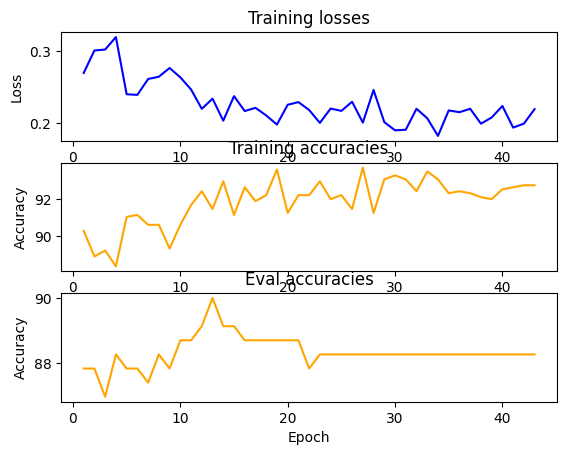

In [61]:
cnn_model = Train_Model(cnn_model, model_type='CNN', learning_rate = 0.1)

In [56]:
class MLP_Net(nn.Module):
  def __init__(self, length):
    super().__init__()
    self.net = nn.Sequential()
    self.net.append(nn.Linear(length, 64))
    self.net.append(nn.ReLU())
    self.net.append(nn.Dropout(0.2))
    self.net.append(nn.Linear(64, 128))
    self.net.append(nn.ReLU())
    self.net.append(nn.Dropout(0.2))
    self.net.append(nn.Linear(128, 64))
    self.net.append(nn.ReLU())
    self.net.append(nn.Dropout(0.2))
    self.net.append(nn.Linear(64, 32))
    self.net.append(nn.ReLU())
    self.net.append(nn.Dropout(0.2))
    self.net.append(nn.Linear(32, num_categories))
  def forward(self, x):
    return self.net(x)

mlp_model = MLP_Net(length=d).double().to(device)
print(mlp_model)

MLP_Net(
  (net): Sequential(
    (0): Linear(in_features=50, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=32, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=32, out_features=5, bias=True)
  )
)


Epoch 001 - Training loss: 0.020 - Training accuracy: 99.25% - Eval accuracy: 91.74% - Learning rate: 0.1
Epoch 002 - Training loss: 0.020 - Training accuracy: 99.36% - Eval accuracy: 92.61% - Learning rate: 0.1
Epoch 003 - Training loss: 0.024 - Training accuracy: 99.04% - Eval accuracy: 93.04% - Learning rate: 0.1
Epoch 004 - Training loss: 0.048 - Training accuracy: 98.72% - Eval accuracy: 91.74% - Learning rate: 0.1
Epoch 005 - Training loss: 0.070 - Training accuracy: 98.08% - Eval accuracy: 91.74% - Learning rate: 0.1
Epoch 006 - Training loss: 0.035 - Training accuracy: 98.93% - Eval accuracy: 92.17% - Learning rate: 0.05
Epoch 007 - Training loss: 0.042 - Training accuracy: 98.93% - Eval accuracy: 92.17% - Learning rate: 0.05
Epoch 008 - Training loss: 0.030 - Training accuracy: 99.36% - Eval accuracy: 92.17% - Learning rate: 0.05
Epoch 009 - Training loss: 0.014 - Training accuracy: 99.57% - Eval accuracy: 92.17% - Learning rate: 0.025
Epoch 010 - Training loss: 0.036 - Traini

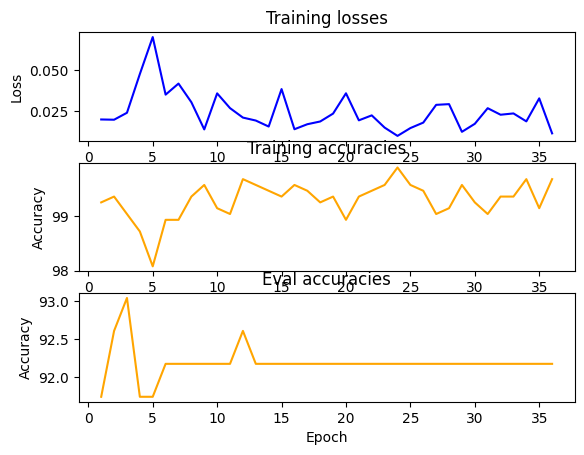

In [62]:
mlp_model = Train_Model(mlp_model, model_type='MLP', learning_rate = 0.1)

In [64]:
output = open(f'./result.csv', 'w')
output.write('id,action')

cnn_model.eval()

prediction = cnn_model(torch.tensor(test_embedding_data).unsqueeze(1).to(device))
  
pre = prediction.argmax(dim=1)
for t in range(len(test_file_names)):
    output.write(f"\n{t},{pre[t]}")

output.close()

In [ ]:
output = open(f'./result.csv', 'w')
output.write('id,action')

mlp_model.eval()
  
prediction = mlp_model(torch.tensor(test_embedding_data).to(device))
  
pre = prediction.argmax(dim=1)
for t in range(len(test_file_names)):
    output.write(f"\n{t},{pre[t]}")

output.close()

### 2. GMLVQ

In [84]:
from sklvq import GMLVQ
from sklearn.metrics import classification_report, accuracy_score

# Define a GMLVQ (Generalized Matrix Learning Vector Quantization) model for classification
model = GMLVQ(
    distance_type="adaptive-squared-euclidean", # Adaptive squared Euclidean distance [1] [2]
    activation_type="swish", # Swish activation function [3]
    solver_type="waypoint-gradient-descent", # Waypoint gradient descent (WGD)[4]
)

In [85]:
train_labels = [mapping_labels[name[name.index('_')+1: name.index('.')]] for name in train_file_names]
eval_labels = [mapping_labels[name[name.index('_')+1: name.index('.')]] for name in eval_file_names]

In [86]:
# Train the model using the scaled data and true labels
model.fit(train_embedding_data, train_labels)

# Predict the labels using the trained model
predicted_labels = model.predict(train_embedding_data)

# Print the classification report
print(classification_report(train_labels, predicted_labels))
print("The accuracy of the GMLVQ model is: ", accuracy_score(train_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       192
           1       0.92      0.92      0.92       182
           2       0.88      0.94      0.91       192
           3       0.96      0.94      0.95       182
           4       0.96      0.89      0.92       189

    accuracy                           0.93       937
   macro avg       0.93      0.93      0.93       937
weighted avg       0.93      0.93      0.93       937

The accuracy of the GMLVQ model is:  0.9252934898612594


In [88]:
predicted_labels = model.predict(test_embedding_data)
output = open(f'./result.csv', 'w')
output.write('id,action')

for t in range(len(test_file_names)):
    output.write(f"\n{t},{predicted_labels[t]}")

output.close()

### 3. Support vector machine

In [89]:
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [90]:
poly = svm.SVC(kernel='poly', degree=3, C=1).fit(train_embedding_data, train_labels)

In [91]:
poly_pred = poly.predict(eval_embedding_data)


In [92]:
poly_accuracy = accuracy_score(eval_labels, poly_pred)
poly_f1 = f1_score(eval_labels, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))


Accuracy (Polynomial Kernel):  92.17
F1 (Polynomial Kernel):  92.12


In [93]:
poly_pred = poly.predict(test_embedding_data)

In [83]:
output = open(f'./result_{version}.csv', 'w')
output.write('id,action')

for t in range(len(test_file_names)):
    output.write(f"\n{t},{poly_pred[t]}")

output.close()